<a href="https://colab.research.google.com/github/yovictoraugusto/DEEPLEARNING/blob/main/DEEPLEARNING_VictorAugustoReisMarques_156620.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import packages
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

In [ ]:
# setting random number seed. Arbitrary seed is OK.
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

# preprocess class for each image
class ImageTransform():

    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                # data augmentation
                transforms.RandomResizedCrop(
                   resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                # convert to tensor for PyTorch
                transforms.ToTensor(),
                # color normalization
                transforms.Normalize(mean, std)
            ]),
            'test': transforms.Compose([
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }

    def __call__(self, img, phase='train'):

        return self.data_transform[phase](img)

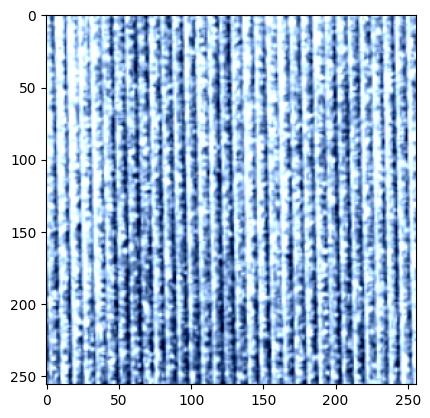

In [ ]:
image_file_path = '/content/drive/MyDrive/IA 1-2024//UCMerced_LandUse/UCMerced_Atividade/test/agricultural/agricultural80.tif'

img_originalsize = Image.open(image_file_path)   # [height][width][color RGB]
img = img_originalsize.resize((256, 256))

img = img.convert("L").convert("RGB")

# original image
# plt.imshow(img)
# plt.show()

# after preprocess
size = 256
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase="train")  # torch.Size([3, 224, 224])

# (color, height, width) -> (height, width, color), normalize colors in the range (0 - 1)
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

In [ ]:
# making file path list
def make_datapath_list(phase="train"):

    rootpath = "/content/drive/MyDrive/IA 1-2024//UCMerced_LandUse/UCMerced_Atividade/"

    target_path = osp.join(rootpath+phase+'/**/*.tif')
    print(target_path)

    path_list = []

    # getting file paths
    for path in glob.glob(target_path):
        path_list.append(path)

    return path_list


train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="test")

/content/drive/MyDrive/IA 1-2024//UCMerced_LandUse/UCMerced_Atividade/train/**/*.tif
/content/drive/MyDrive/IA 1-2024//UCMerced_LandUse/UCMerced_Atividade/test/**/*.tif


In [ ]:
# making dataset

class CustomDataset(data.Dataset):

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):

        # load image
        img_path = self.file_list[index]

        img_originalsize = Image.open(img_path)
        # resize
        img = img_originalsize.resize((256, 256))

        # grey -> color
        img = img.convert("L").convert("RGB")

        # preprocess
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])

        # picking up labels
        if self.phase == "train":
            label = img_path[25:img_path.rfind('/')]

        # print(label)

        # label char -> number
        if label == "agricultural":
            label = 0

        elif label == "airplane":
            label = 1

        elif label == "baseballdiamond":
            label = 2

        elif label == "beach":
            label = 3

        elif label == "buildings":
            label = 4

        elif label == "chaparral":
            label = 5

        elif label == "denseresidential":
            label = 6

        elif label == "forest":
            label = 7

        elif label == "freeway":
            label = 8

        elif label == "golfcourse":
            label = 9

        elif label == "harbor":
            label = 10

        elif label == "intersection":
            label = 11

        elif label == "mediumresidential":
            label = 12

        elif label == "mobilehomepark":
            label = 13

        elif label == "overpass":
            label = 14

        elif label == "parkinglot":
            label = 15

        elif label == "river":
            label = 16

        elif label == "runway":
            label = 17

        elif label == "sparseresidential":
            label = 18

        elif label == "storagetanks":
            label = 19

        elif label == "tenniscourt":
            label = 20

        return img_transformed, label

# run
train_dataset = CustomDataset(
    file_list=train_list, transform=ImageTransform(size, mean, std), phase='train')

val_dataset = CustomDataset(
    file_list=val_list, transform=ImageTransform(size, mean, std), phase='test')

In [ ]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

dataloaders_dict = {"train": train_dataloader, "test": test_dataloader}

# motion check
# batch_iterator = iter(dataloaders_dict["train"])

# inputs, labels = next(
#     batch_iterator)  # pick up first element
# print(inputs.size())
# print(labels)

In [ ]:
# load pretrained vgg16 from PyTorch as an instance
# need to make setting 'internet' to 'On'.
use_pretrained = True
net = models.vgg16(pretrained=use_pretrained)

# Replace output layer for 2 class classifier, 'NORMAL' and 'PNEUMONIA'.
net.classifier[6] = nn.Linear(in_features=4096, out_features=21)

net.train()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# setting of loss function
criterion = nn.CrossEntropyLoss()

# setting fine tuned parameters

params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

# Not only output layer, "features" layers and other classifier layers are tuned.
update_param_names_1 = ["features"]
update_param_names_2 = ["classifier.0.weight",
                        "classifier.0.bias", "classifier.3.weight", "classifier.3.bias"]
update_param_names_3 = ["classifier.6.weight", "classifier.6.bias"]

# store parameters in list
for name, param in net.named_parameters():
    if update_param_names_1[0] in name:
        param.requires_grad = True
        params_to_update_1.append(param)
        #print("params_to_update_1:", name)

    elif name in update_param_names_2:
        param.requires_grad = True
        params_to_update_2.append(param)
        #print("params_to_update_2:", name)

    elif name in update_param_names_3:
        param.requires_grad = True
        params_to_update_3.append(param)
        #print("params_to_update_3:", name)

    else:
        param.requires_grad = False
        #print("no learning", name)

# print("-----------")
# print(params_to_update_1)

# Learning Rates
optimizer = optim.SGD([
    {'params': params_to_update_1, 'lr': 1e-4},
    {'params': params_to_update_2, 'lr': 5e-4},
    {'params': params_to_update_3, 'lr': 1e-3}
], momentum=0.9)

In [ ]:
# training function
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    accuracy_list = []
    loss_list = []

    # Precondition : Accelerator GPU -> 'On'
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using device：", device)

    # put betwork into GPU
    net.to(device)
    torch.backends.cudnn.benchmark = True

    # epoch loop
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        for phase in ['train']:
            if phase == 'train':
                net.train()  # set network 'train' mode

            epoch_loss = 0.0
            epoch_corrects = 0

            # Before training
            if (epoch == 0) and (phase == 'train'):
                continue


            # batch loop
            for inputs, labels in tqdm(dataloaders_dict[phase]):

                # print(labels)

                # send data to GPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # initialize optimizer
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)

                    # print(outputs.shape)

                    loss = criterion(outputs, labels)  #calcurate loss
                    preds = torch.argmax(outputs, 1)  # predict

                    # back propagtion
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    print(preds)
                    print(labels.data)

                    # update loss summation
                    epoch_loss += loss.item() * inputs.size(0)
                    # update correct prediction summation
                    print(type(labels.data))
                    epoch_corrects += torch.sum(torch.Tensor(preds) == labels.data)

            # loss and accuracy for each epoch loop
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

    return accuracy_list, loss_list


In [ ]:
# start training
num_epochs=50
accuracy_list, loss_list = train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

using device： cuda:0
Epoch 1/50
-------------
Epoch 2/50
-------------


  0%|          | 0/53 [00:09<?, ?it/s]


AttributeError: 'tuple' object has no attribute 'to'

In [ ]:
# To save trained model
save_path = './weights_fine_tuning.pth'
torch.save(net.state_dict(), save_path)

In [ ]:
epoch_num = list(range(10))
fig, ax = plt.subplots(facecolor="w")
ax.plot(epoch_num, accuracy_list, label="accuracy")
ax.plot(epoch_num, loss_list, label="loss")
plt.xticks(epoch_num)

ax.legend()

plt.show()

Infelizmente não consegui fazer rodar, está aparecendo o um erro:
"AttributeError                            Traceback (most recent call last)
<ipython-input-27-12f9e14a4ff3> in <cell line: 3>()
      1 # start training
      2 num_epochs=50
----> 3 accuracy_list, loss_list = train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

<ipython-input-26-41b01b073644> in train_model(net, dataloaders_dict, criterion, optimizer, num_epochs)
     37                 # send data to GPU
     38                 inputs = inputs.to(device)
---> 39                 labels = labels.to(device)
     40
     41                 # initialize optimizer

AttributeError: 'tuple' object has no attribute 'to'"

E não sei como arrumar